In [1]:
# MGMTMFE 431 - Quantitative Asset Management
# Problem Set 3
# Akhil Srivastava

# Downloads and saves CRSP raw data
def download_raw_crsp_data(data_dir, wrds_id):
    ###################################### Download CRSP stock data ######################################
    
    # Download CRSP stock monthly returns
    # Reference - Assignment Instruction:
    # "This should be the full dataset available on WRDS; do not pre-filter by SHRCD, EXCHCD, or date."
    conn = wrds.Connection(wrds_username=wrds_id)
    mscrsp_raw = conn.raw_sql("""select a.permno, a.permco, a.date, b.shrcd, b.exchcd, a.ret, a.retx, a.shrout, a.prc
                                from crspq.msf as a
                                left join crspq.msenames as b
                                on a.permno=b.permno and b.namedt<=a.date and a.date<=b.nameendt""")    
    # Store downloaded data in pickle format
    mscrsp_raw.to_pickle(data_dir + 'mscrsp_raw.pkl')

    # Download CRSP stock monthly delisting returns
    msdelcrsp_raw = conn.raw_sql("""select permno, dlret, dlstdt, dlstcd from crspq.msedelist""")
    # Store downloaded data in pickle format
    msdelcrsp_raw.to_pickle(data_dir + 'msdelcrsp_raw.pkl')

    # Close WRDS API connection
    conn.close()
    
def download_ff3_monthly_data(data_dir):
    # Download and save FF3 monthly data
    FF_mkt = pandas_datareader.famafrench.FamaFrenchReader('F-F_Research_Data_Factors',
                                                           start='1900',
                                                           end=str(datetime.datetime.now().year+1))
    FF_mkt = FF_mkt.read()[0]/100

    FF_mkt['Date'] = pd.to_datetime(FF_mkt.index, format='%Y-%m-%d', errors='ignore')
    FF_mkt['Year'] = FF_mkt['Date'].dt.year
    FF_mkt['Month'] = FF_mkt['Date'].dt.month
    FF_mkt.drop(['Date'], axis=1, inplace=True)

    FF_mkt.columns = ['Market_minus_Rf', 'SMB', 'HML', 'Rf', 'Year', 'Month']
    FF_mkt = FF_mkt[['Year', 'Month', 'Market_minus_Rf', 'SMB', 'HML', 'Rf']]
    
    # Filter dates
    FF_mkt = FF_mkt[FF_mkt['Year'] >= min_year]
    FF_mkt = FF_mkt[FF_mkt['Year'] <= max_year]

    # Store downloaded data in pickle format
    FF_mkt.to_pickle(data_dir + 'ff3_monthly.pkl')

In [2]:
# Processes and saves raw CRSP stock returns and delisted returns data to create a merged dataframe
def process_raw_crsp_stock_data(data_dir, mscrsp_raw, msdelcrsp_raw):
    print("      Processing raw data for stocks ...")
    
    ############################### Process raw CRSP returns ###############################
    
    # Sort the data by permno and date and reset index as sometimes there are redundant indices
    mscrsp_raw = mscrsp_raw.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
    
    # Drop rows with missing 'shrcd', 'exchcd' and 'shrout'
    # Otherwise conversion to integer leads to exception
    mscrsp_raw = mscrsp_raw[mscrsp_raw['shrcd'].notna() &
                            mscrsp_raw['exchcd'].notna() &
                            mscrsp_raw['shrout'].notna()].copy()

    # Reference - Assignment Instruction: PERMNO, SHRCD, EXCHCD and SHROUT variables have type integer
    int_columns = ['permno', 'permco', 'shrcd', 'exchcd', 'shrout']
    mscrsp_raw[int_columns] = mscrsp_raw[int_columns].astype(int)

    # Reference - Assignment Instruction: Format the date column as a datetime
    mscrsp_raw['date'] = pd.to_datetime(mscrsp_raw['date'], format='%Y-%m-%d', errors='ignore')

    # Sort the data by permno and date and reset index because we dropped rows above
    mscrsp_raw = mscrsp_raw.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
    
    ########################## Process raw CRSP delisting returns ##########################
    
    # Sort the data by permno and date and reset index as sometimes there are redundant indices
    msdelcrsp_raw = msdelcrsp_raw.sort_values(by=['permno', 'dlstdt']).reset_index(drop=True).copy()
    
    # Reference - Assignment Instruction: PERMNO variable has type integer
    msdelcrsp_raw['permno'] = msdelcrsp_raw['permno'].astype(int)

    # Reference - Assignment Instruction: Format the date column as a datetime
    msdelcrsp_raw = msdelcrsp_raw.rename(columns={"dlstdt": "date"}).copy()
    msdelcrsp_raw['date'] = pd.to_datetime(msdelcrsp_raw['date'], format='%Y-%m-%d', errors='ignore')

    # Sort the data by permno and date and reset index
    msdelcrsp_raw = msdelcrsp_raw.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
    
    ##################### Merge CRSP stock returns with the delisting returns #####################

    # Keep all the rows, don't drop anything yet
    mscrsp_processed = mscrsp_raw.merge(msdelcrsp_raw, how='outer', on=['date', 'permno'])
    # Sort the data by permno and date and reset index
    mscrsp_processed = mscrsp_processed.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
    
    # Store Processed merged CRSP data in pickle format
    mscrsp_processed.to_pickle(data_dir + 'mscrsp_processed.pkl')
    
# Process and store raw DM and KRF returns
def process_raw_DM_KRF_returns(data_dir, DM_returns_file, KRF_returns_file):
    print("      Processing raw DM and KRF returns ...")
    
    ############################### Process raw DM returns ###############################    
    # Load DM raw returns
    DM_returns = pd.read_table(data_dir + DM_returns_file,
                               header=None,
                               names=["date", "decile", "DM_Ret_2", "d", "e"],
                               sep='\s+')
    
    # Convert "date" to datetime
    DM_returns["date"] = pd.to_datetime(DM_returns["date"], format="%Y%m%d")
    
    # Compute Year and Month
    DM_returns["Year"] = DM_returns["date"].dt.year
    DM_returns["Month"] = DM_returns["date"].dt.month
    
    # Drop unreqiured columns
    DM_returns.drop(columns=["date", "d", "e"], inplace=True)    
    
    # Store processed data in pickle format
    DM_returns.to_pickle(data_dir + 'DM_returns.pkl')
    
    ############################### Process raw KRF returns ###############################

    # Create list of decile strings
    decile_cols = []
    for i in range(1, 11):
        decile_cols.append("Decile " + str(i))
    KRF_cols = ["date"] + decile_cols
    
    # Load raw KRF returns
    KRF_returns = pd.read_csv(data_dir + "10_Portfolios_Prior_12_2.csv",
                              names=KRF_cols,
                              skiprows = 11,
                              nrows=1167,
                              engine="python")
    
    # Convert date to datetime
    KRF_returns["date"] = pd.to_datetime(KRF_returns["date"], format="%Y%m")

    # Compute Year and Month
    KRF_returns["Year"] = KRF_returns["date"].dt.year
    KRF_returns["Month"] = KRF_returns["date"].dt.month

    # Drop unreqiured columns
    KRF_returns.drop(columns=["date"], inplace=True)

    # Convert returns to fraction
    KRF_returns[decile_cols] = KRF_returns[decile_cols]/100
    
    # Filter dates
    KRF_returns = KRF_returns[KRF_returns['Year'] >= min_year]
    KRF_returns = KRF_returns[KRF_returns['Year'] <= max_year]
    
    # Rename decile columns to digits
    col_mapping = {}
    for i in range(1, 11):
        col_mapping["Decile " + str(i)] = str(i)    
    KRF_returns = KRF_returns.rename(columns=col_mapping)

    # Store processed data in pickle format
    KRF_returns.to_pickle(data_dir + 'KRF_returns.pkl')

In [3]:
# Implements PS3-Q1 requirements: Inputs - CRSP_Stocks
def PS3_Q1(CRSP_Stocks):
    print("Recomputing ranking returns ...")
    # Reference - Kenneth R. French:
    # "Rm-Rf, the excess return on the market, value-weight return of all CRSP firms incorporated in the US and
    # listed on the NYSE, AMEX, or NASDAQ that have a CRSP share code of 10 or 11 at the beginning of month t,
    # good shares and price data at the beginning of t, and good return data for t minus the one-month Treasury bill rate."

    # Filter relevant exchcd - Reference - Kenneth R. French: "listed on the NYSE, AMEX, or NASDAQ"
    exchcd_set = [1, 2, 3, 31, 32, 33]
    # Filter relevant shrcd - Reference - Kenneth R. French: "that have a CRSP share code of 10 or 11"
    shrcd_set = [10, 11]

    # Move all dates to the last day of the month
    CRSP_Stocks['date'] = CRSP_Stocks['date'] + MonthEnd(0)
    # Sort again as we changed date values
    CRSP_Stocks = CRSP_Stocks.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()

    # exchcd/shrcd are nan for delisted returns, so filtering rows on required exchcd/shrcd removes delisted return rows
    # dlstcd is not-nan for all the delisted return rows, so it has been used as a proxy to identify delisted return rows
    # Rows with unrequired exchcd/shrcd are removed only if those are non delisted return row
    CRSP_Stocks = CRSP_Stocks[(CRSP_Stocks['dlstcd'].notna()) |
                              ((CRSP_Stocks['dlstcd'].isna()) & (CRSP_Stocks['exchcd'].isin(exchcd_set)))]

    CRSP_Stocks = CRSP_Stocks[(CRSP_Stocks['dlstcd'].notna()) |
                              ((CRSP_Stocks['dlstcd'].isna()) & (CRSP_Stocks['shrcd'].isin(shrcd_set)))]
    # Drop unrequired columns
    CRSP_Stocks.drop(['shrcd'], axis=1, inplace=True)

    # Calculate market equity in USD millions
    # Use absolute price because if price is bid/ask average it has a negative sign to indicate so
    CRSP_Stocks['me'] = CRSP_Stocks['prc'].abs()*CRSP_Stocks['shrout']*1e-3
    # Drop unrequired columns
    CRSP_Stocks.drop(['prc', 'shrout'], axis=1, inplace=True)

    # Adjust for Delisting Returns
    # Use compounded return if both return and delisted return are available
    CRSP_Stocks['ret'] = np.where(CRSP_Stocks['ret'].notna() & CRSP_Stocks['dlret'].notna(),
                          (1 + CRSP_Stocks['ret'])*(1 + CRSP_Stocks['dlret']) - 1,
                          CRSP_Stocks['ret'])
    # Use delisted return if return is not available but delited return is
    CRSP_Stocks['ret'] = np.where(CRSP_Stocks['ret'].isna() & CRSP_Stocks['dlret'].notna(),
                          CRSP_Stocks['dlret'],
                          CRSP_Stocks['ret'])
    # Drop missing returns
    CRSP_Stocks = CRSP_Stocks[CRSP_Stocks['ret'].notna()].copy()
    # Reset index
    CRSP_Stocks = CRSP_Stocks.sort_values(by=['permno','date']).reset_index(drop=True).copy()
   
    # Aggregate Market Cap. computation
    # For a given date and permco, sum me across different permno to find cumulative market-cap for the permco
    CRSP_Stocks_ME_SUM = CRSP_Stocks.groupby(['date','permco'])['me'].sum().reset_index()
    # For a given date and permco, among multiple market-caps for different permno find the largest one
    CRSP_Stocks_ME_MAX = CRSP_Stocks.groupby(['date','permco'])['me'].max().reset_index()
    # Merge CRSP_Stocks and CRSP_Stocks_ME_MAX
    CRSP_Stocks = pd.merge(CRSP_Stocks, CRSP_Stocks_ME_MAX, how='inner', on=['date', 'permco', 'me'])
    # Replace me with cumulative me
    # Drop existing me
    CRSP_Stocks = CRSP_Stocks.drop(['me'], axis=1)
    # Merge CRSP_Stocks and CRSP_Stocks_ME_SUM to use cumulative market cap
    CRSP_Stocks = pd.merge(CRSP_Stocks, CRSP_Stocks_ME_SUM, how='inner', on=['date', 'permco'])
    # Sort by permno and date and drop duplicates
    CRSP_Stocks = CRSP_Stocks.sort_values(by=['permno', 'date']).drop_duplicates()

    # lagged Market Cap. computation
    # Add column with lagged market cap
    CRSP_Stocks['lme'] = CRSP_Stocks.groupby(['permno'])['me'].shift(1)
    # If a permno is the first permno, use me/(1+retx) to replace the missing value
    CRSP_Stocks['1+retx'] = 1 + CRSP_Stocks['retx']
    CRSP_Stocks['count'] = CRSP_Stocks.groupby(['permno']).cumcount()
    CRSP_Stocks['lme'] = np.where(CRSP_Stocks['count'] == 0, CRSP_Stocks['me']/CRSP_Stocks['1+retx'], CRSP_Stocks['lme'])    
    # Drop missing lme
    CRSP_Stocks = CRSP_Stocks[CRSP_Stocks['lme'].notna()].copy()
    # Reset index
    CRSP_Stocks = CRSP_Stocks.sort_values(by=['permno','date']).reset_index(drop=True).copy()
    
    # Data integrity checkes
    assert (CRSP_Stocks['ret'] == -66).any() == False
    assert (CRSP_Stocks['ret'] == -77).any() == False
    assert (CRSP_Stocks['ret'] == -88).any() == False
    assert (CRSP_Stocks['ret'] == -99).any() == False
    assert CRSP_Stocks['ret'].isna().any() == False
    assert CRSP_Stocks['lme'].isna().any() == False
    
    # Compute Ranking_Ret
    # create a subset with relevant columns
    CRSP_Stocks_Subset = CRSP_Stocks[['permno','date','ret']].sort_values(['permno','date']).set_index('date')
    # Compute log return
    CRSP_Stocks_Subset["log_Ret"] = np.log(1 + CRSP_Stocks_Subset["ret"])
    # Move log retun by 2 months
    # Reference - Daniel and Moskowitz (2016)
    # "rank stocks based on their cumulative returns from 12 months before to one month -
    # before the formation date (i.e., the t −12 to t −2 -month returns),"
    CRSP_Stocks_Subset["lag2_log_ret"] = CRSP_Stocks_Subset.groupby(["permno"])["log_Ret"].shift(2)
    # Compute cumulative log return for t-12 to t-2
    CRSP_Stocks_Cum_Ret = CRSP_Stocks_Subset.groupby(["permno"])["lag2_log_ret"].rolling(11).sum().reset_index()
    # Rename cumulative log return column to Ranking_Ret
    CRSP_Stocks_Cum_Ret = CRSP_Stocks_Cum_Ret.rename(columns = {"lag2_log_ret" : "Ranking_Ret"})
    # Merge with CRSP_Stocks and CRSP_Stocks_Cum_Ret to create CRSP_Stocks_Momentum
    CRSP_Stocks_Momentum = pd.merge(CRSP_Stocks, CRSP_Stocks_Cum_Ret, on=["permno", "date"])

    # Compute required monthly values
    CRSP_Stocks_Momentum['Year'] = CRSP_Stocks_Momentum['date'].dt.year
    CRSP_Stocks_Momentum['Month'] = CRSP_Stocks_Momentum['date'].dt.month
    
    # Drop Unrequired columns
    CRSP_Stocks_Momentum.drop(['permco', 'retx', 'dlret', 'dlstcd', 'me', '1+retx', 'count', 'date'], axis=1, inplace=True)

    # Rename columns to match assignment instructions
    CRSP_Stocks_Momentum = CRSP_Stocks_Momentum.rename(columns = {"lme" : "lag_Mkt_Cap", "ret" : "Ret"})
    
    # Filter dates
    CRSP_Stocks_Momentum = CRSP_Stocks_Momentum[CRSP_Stocks_Momentum['Year'] >= min_year]
    CRSP_Stocks_Momentum = CRSP_Stocks_Momentum[CRSP_Stocks_Momentum['Year'] <= max_year]

    # Store final data in pickle format
    CRSP_Stocks_Momentum.to_pickle(data_dir + 'CRSP_Stocks_Momentum.pkl')
    
    return CRSP_Stocks_Momentum

In [4]:
def apply_nyse_breakpoints(df, df_nyse_breakpoints):
    # Find relevant row in NYSE break-points dataframe    
    rel_row = df_nyse_breakpoints[(df_nyse_breakpoints.Year == df.Year.values[0]) &
                                  (df_nyse_breakpoints.Month == df.Month.values[0])]
    # Extract break-point values
    break_points = rel_row.values[0][2:]
    # Append -inf and inf
    break_points = np.concatenate([[-np.inf], break_points, [np.inf]])
    # Apply NYSE break-points
    KRF_deciles = pd.cut(df["Ranking_Ret"], break_points, labels=range(1, 11))
    
    return KRF_deciles

In [5]:
# Implements PS3-Q2 requirements: Input - CRSP_Stocks_Momentum
def PS3_Q2(CRSP_Stocks_Momentum):
    # Create a copy of the dataframe to be used locally
    CRSP_Stocks_Momentum_decile = CRSP_Stocks_Momentum.copy()

    # Compute DM decile using all the stocks
    RR_By_YM = CRSP_Stocks_Momentum_decile.groupby(["Year", "Month"])["Ranking_Ret"]
    CRSP_Stocks_Momentum_decile["DM_decile"] = RR_By_YM.transform(lambda x: pd.qcut(x, 10, labels=range(1, 11)))
    
    # Filter NYSE data
    CRSP_Stocks_NYSE = CRSP_Stocks_Momentum_decile[CRSP_Stocks_Momentum_decile['exchcd'] == 1]
    
    # Find NYSE percentiles
    req_percentiles = np.arange(0.1, 1, 0.1)
    NYSE_RR_By_YM = CRSP_Stocks_NYSE.groupby(["Year", "Month"])["Ranking_Ret"]
    NYSE_percentiles = NYSE_RR_By_YM.describe(percentiles=req_percentiles).reset_index()
    
    # Find NYSE breakpoints
    breakpoints_str = [str(x) + "%" for x in range(10, 100, 10)]
    NYSE_breakpoints = NYSE_percentiles[["Year", "Month"] + breakpoints_str]

    # Apply NYSE breakpoints
    KRF_deciles = CRSP_Stocks_Momentum_decile.groupby(["Year", "Month"]).apply(apply_nyse_breakpoints,
                                                                               NYSE_breakpoints).reset_index([0,1])

    # Add KRF_deciles to CRSP_Stocks_Momentum_decile
    CRSP_Stocks_Momentum_decile["KRF_decile"] = KRF_deciles["Ranking_Ret"]
    
    # Store final data in pickle format
    CRSP_Stocks_Momentum_decile.to_pickle(data_dir + 'CRSP_Stocks_Momentum_decile.pkl')
    
    return CRSP_Stocks_Momentum_decile

In [6]:
# Implements PS3-Q3 requirements:: Inputs - CRSP_Stocks_Momentum_decile and FF_mkt
def PS3_Q3(CRSP_Stocks_Momentum_decile, FF_mkt):
    # Calculate DM_Ret
    gp_cols_dm = ["Year", "Month", "DM_decile"]
    group_dm = CRSP_Stocks_Momentum_decile.groupby(gp_cols_dm)
    DM_Ret = group_dm.apply(lambda x: np.average(x.Ret, weights=x.lag_Mkt_Cap)).reset_index([0,1,2])
    DM_Ret = DM_Ret.rename(columns = {0 : "DM_Ret"})
    
    # Calculate KRF_Ret
    gp_cols_krf = ["Year", "Month", "KRF_decile"]
    group_krf = CRSP_Stocks_Momentum_decile.groupby(gp_cols_krf)
    KRF_Ret = group_krf.apply(lambda x: np.average(x.Ret, weights=x.lag_Mkt_Cap)).reset_index([0,1,2])
    KRF_Ret = KRF_Ret.rename(columns = {0 : "KRF_Ret"})
    
    # Join DM_Ret and KRF_Ret to create CRSP_Stocks_Momentum_returns
    CRSP_Stocks_Momentum_returns = DM_Ret.join(KRF_Ret["KRF_Ret"])
    CRSP_Stocks_Momentum_returns = CRSP_Stocks_Momentum_returns.rename(columns = {"DM_decile" : "decile"})
    
    # Add famma-french rf data
    CRSP_Stocks_Momentum_returns = pd.merge(CRSP_Stocks_Momentum_returns, FF_mkt[["Year", "Month", "Rf"]], how='outer')
    
    # Store final data in pickle format
    CRSP_Stocks_Momentum_returns.to_pickle(data_dir + 'CRSP_Stocks_Momentum_returns.pkl')
    
    return CRSP_Stocks_Momentum_returns

In [91]:
# Implements PS3-Q4/5 requirements:: Inputs - CRSP_Stocks_Momentum_returns, and Return Column Name
def PS3_Q4_5_Common(CRSP_Stocks_Momentum_returns, Ret_Col):
    # Create a copy of the dataframe to be used locally
    CRSP_Stocks_Momentum_returns = CRSP_Stocks_Momentum_returns.copy()

    # Create dataframe to store required stats
    df_stats = pd.DataFrame()

    # Compute excess return
    CRSP_Stocks_Momentum_returns["Ex_Ret"] = CRSP_Stocks_Momentum_returns[Ret_Col] - CRSP_Stocks_Momentum_returns['Rf']
    
    # Compute required stats
    gp_decile = CRSP_Stocks_Momentum_returns.groupby("decile")
    df_stats["Excess Return"] = 100*12*gp_decile["Ex_Ret"].mean()
    df_stats["Volatility"] = 100*np.sqrt(12)*gp_decile["Ex_Ret"].std()
    df_stats["Sharpe Ratio"] = df_stats["Excess Return"]/df_stats["Volatility"]
    df_stats["Skewness"] = gp_decile["Ex_Ret"].skew()
    df_stats["Ex_Ret t-stat-all"] = gp_decile.apply(lambda x: ttest_1samp(x.Ex_Ret, 0, axis=0).statistic)
    df_stats["Ex_Ret t-stat-5yr"] = gp_decile.apply(lambda x: ttest_1samp(x.Ex_Ret[-60:], 0, axis=0).statistic)
    
    # Compute Winner and loser returns
    WML_Ret = gp_decile.get_group(10)["Ex_Ret"].values - gp_decile.get_group(1)["Ex_Ret"].values
    WML_Ex_Ret = WML_Ret + gp_decile.get_group(10)["Rf"].values
    
    # Append WML stats
    df_stats.loc["WML", "Excess Return"] = 100*12*WML_Ex_Ret.mean()
    df_stats.loc["WML", "Volatility"] = 100*np.sqrt(12)*WML_Ex_Ret.std()
    df_stats.loc["WML", "Sharpe Ratio"] = df_stats.loc["WML", "Excess Return"]/df_stats.loc["WML", "Volatility"]
    df_stats.loc["WML", "Skewness"] = skew(WML_Ex_Ret)
    df_stats.loc["WML", "Ex_Ret t-stat-all"] = ttest_1samp(WML_Ex_Ret, [0], axis=0).statistic
    df_stats.loc["WML", "Ex_Ret t-stat-5yr"] = ttest_1samp(WML_Ex_Ret[-60:], [0], axis=0).statistic
    
    return df_stats

In [94]:
# Implements PS3-Q4 requirements:: Inputs - CRSP_Stocks_Momentum_returns and DM_Returns
def PS3_Q4(CRSP_Stocks_Momentum_returns, DM_Returns):
    # Compute required common stats
    df_ps3_q4 = PS3_Q4_5_Common(CRSP_Stocks_Momentum_returns, "DM_Ret")
    
    # Merge CRSP_Stocks_Momentum_returns and DM_Returns to get common data
    df_returns = pd.merge(CRSP_Stocks_Momentum_returns, DM_Returns, how='inner', on=["Year", "Month", "decile"])
    
    # Compute excess returns for the common data
    df_returns["Ex_Ret"] = df_returns["DM_Ret"] - df_returns['Rf']
    df_returns["Ex_Ret_Auth"] = df_returns["DM_Ret_2"] - df_returns['Rf']
    
    # Create group by deciles for the common data
    gp_decile = df_returns.groupby("decile")
    
    # Compute Winner and loser returns for the common data
    WML_Ret = gp_decile.get_group(10)["Ex_Ret"].values - gp_decile.get_group(1)["Ex_Ret"].values
    WML_Ex_Ret = WML_Ret + gp_decile.get_group(10)["Rf"].values
    
    # Compute Author Winner and loser returns for the common data
    WML_Ret_Auth = gp_decile.get_group(10)["Ex_Ret_Auth"].values - gp_decile.get_group(1)["Ex_Ret_Auth"].values
    WML_Ex_Ret_Auth = WML_Ret_Auth - gp_decile.get_group(10)["Rf"].values
    
    # Compute correlations
    df_ps3_q4["corr w/ original"] = gp_decile.apply(lambda x: np.corrcoef(x.Ex_Ret, x.Ex_Ret_Auth)[0, 1])
    df_ps3_q4.loc["WML", "corr w/ original"] = np.corrcoef(WML_Ex_Ret, WML_Ex_Ret_Auth)[0, 1]
    
    return df_ps3_q4.T

In [112]:
# Implements PS3-Q5 requirements:: Inputs - CRSP_Stocks_Momentum_returns and KRF_Returns
def PS3_Q5(CRSP_Stocks_Momentum_returns, KRF_Returns):
    # Compute required common stats
    df_ps3_q5 = PS3_Q4_5_Common(CRSP_Stocks_Momentum_returns, "KRF_Ret")
    
    # Create a copy of the dataframe to be used locally
    df_returns = CRSP_Stocks_Momentum_returns.copy()
    
    # Compute excess returns for CRSP_Stocks_Momentum_returns
    df_returns["Ex_Ret"] = df_returns["DM_Ret"] - df_returns['Rf']    
    # Create group by deciles for CRSP_Stocks_Momentum_returns
    gp_decile = df_returns.groupby("decile")
    # Compute Winner minus loser returns for CRSP_Stocks_Momentum_returns
    WML_Ret = gp_decile.get_group(10)["Ex_Ret"].values - gp_decile.get_group(1)["Ex_Ret"].values
    WML_Ex_Ret = WML_Ret + gp_decile.get_group(10)["Rf"].values
    
    # Array to store colleation values
    correlations = np.zeros(11)
    
    # Compute correlation for deciles    
    for i in range(10):
        Ex_Ret_Self = gp_decile.get_group(i+1)["Ex_Ret"].values
        Ex_Ret_Auth = KRF_Returns[str(i+1)].values - gp_decile.get_group(i+1)["Rf"].values
        correlations[i] = np.corrcoef(Ex_Ret_Self, Ex_Ret_Auth)[0, 1]
    
    # Compute Author Winner minus loser returns
    WML_Ret_Auth = KRF_Returns["10"] - KRF_Returns["1"]
    WML_Ex_Ret_Auth = WML_Ret_Auth - gp_decile.get_group(10)["Rf"].values
    
    # Compute correlation for WML
    correlations[10] = np.corrcoef(WML_Ex_Ret, WML_Ex_Ret_Auth)[0, 1]
    
    # Append correlation to the stats df
    df_ps3_q5["corr w/ original"] = correlations

    # PLot returns
    time_str = KRF_Returns["Year"].astype(str).values + KRF_Returns["Month"].astype(str).values
    time = pd.to_datetime(time_str, format="%Y%m")
    dec_10_ex_ret = gp_decile.get_group(10)["Ex_Ret"].values[-120:]
    dec_1_ex_ret = gp_decile.get_group(1)["Ex_Ret"].values[-120:]
    wml_ex_ret = WML_Ex_Ret[-120:]
    plt.figure(figsize=(16, 8))
    plt.plot(time.values[-120:], dec_10_ex_ret, "--", label="Decile 10", color="midnightblue")
    plt.plot(time.values[-120:], dec_1_ex_ret, "--", label="Decile 1", color="red")
    plt.plot(time.values[-120:], wml_ex_ret, "--", label="WML", color="gold")
    plt.title("Momentum Excess Returns [2014 - 2023]", fontsize=18)
    plt.xlabel("Time", fontsize=15)
    plt.ylabel("Return", fontsize=15)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show();
    
    # PLot t-stats    
    plt.figure(figsize=(16, 8))
    plt.plot(df_ps3_q5.index.values[:-1], df_ps3_q5["Ex_Ret t-stat-all"].values[:-1], "-o",
             label="1927-2023", color="midnightblue")
    plt.plot(df_ps3_q5.index.values[:-1], df_ps3_q5["Ex_Ret t-stat-5yr"].values[:-1], "-o",
             label="2019-2023", color="red")  
    plt.title("Momentum Excess Returns t-stats", fontsize=18)
    plt.xlabel("Decile", fontsize=15)
    plt.ylabel("t-stat", fontsize=15)
    plt.grid(True)
    plt.legend(fontsize=12)
    plt.show();
    
    return df_ps3_q5.T

In [113]:
# Processes raw CRSP data downloaded from WRDS for each asset class
def process_raw_data():
    # Load stored raw CRSP stock returns data as a dataframe
    mscrsp_raw = pd.read_pickle(data_dir + 'mscrsp_raw.pkl')

    # Load stored raw CRSP stock delisting returns data as a dataframe
    msdelcrsp_raw = pd.read_pickle(data_dir + 'msdelcrsp_raw.pkl')
    
    # Process and store raw CRSP stock returns and delisting returns
    process_raw_crsp_stock_data(data_dir, mscrsp_raw, msdelcrsp_raw)
    
    # Process and store raw DM returns and KRF returns
    process_raw_DM_KRF_returns(data_dir, DM_returns_file, KRF_returns_file)
    
# Computes ranking return
def compute_ranking_returns(recompute=False):
    # If recumpute is set to true, recompute ranking return
    if recompute == True:
        # Load processed CRSP stock data as dataframe
        CRSP_Stocks = pd.read_pickle(data_dir + 'mscrsp_processed.pkl')
        # Calculate ranking return
        CRSP_Stocks_Momentum = PS3_Q1(CRSP_Stocks)
    # Otherwise load pre-computed data from the stored pickle files
    else:
        print("Loading ranking returns from the pickle file ...")        
        # Load stored CRSP_Stocks_Momentum data as a dataframe
        CRSP_Stocks_Momentum = pd.read_pickle(data_dir + 'CRSP_Stocks_Momentum.pkl')
        
    return CRSP_Stocks_Momentum

Skipped data downloading!
Skipped raw data processing!


decile,1,2,3,4,5,6,7,8,9,10,WML
Excess Return,-1.6436,2.8658,3.8028,6.7966,7.9802,7.4427,9.4996,10.3162,11.4200,15.3753,20.2309
Volatility,36.8774,30.1171,25.7879,22.6675,21.3386,19.9808,19.1265,18.7036,19.9418,23.6006,30.2215
Sharpe Ratio,-0.0446,0.0952,0.1475,0.2998,0.3740,0.3725,0.4967,0.5516,0.5727,0.6515,0.6694
Skewness,1.3881,1.3267,1.0885,1.0501,1.2244,0.8451,0.0637,-0.0044,-0.2387,-0.3557,-1.8153
Ex_Ret t-stat-all,-0.4389,0.9372,1.4524,2.9531,3.6833,3.6686,4.8917,5.4323,5.6401,6.4164,6.5902
Ex_Ret t-stat-5yr,0.2574,0.8197,0.8240,1.2917,1.6935,0.9974,1.9119,1.3207,1.2879,1.7766,0.7910
corr w/ original,0.9956,0.9965,0.9962,0.9969,0.9971,0.9982,0.9982,0.9985,0.9982,0.9985,0.9903


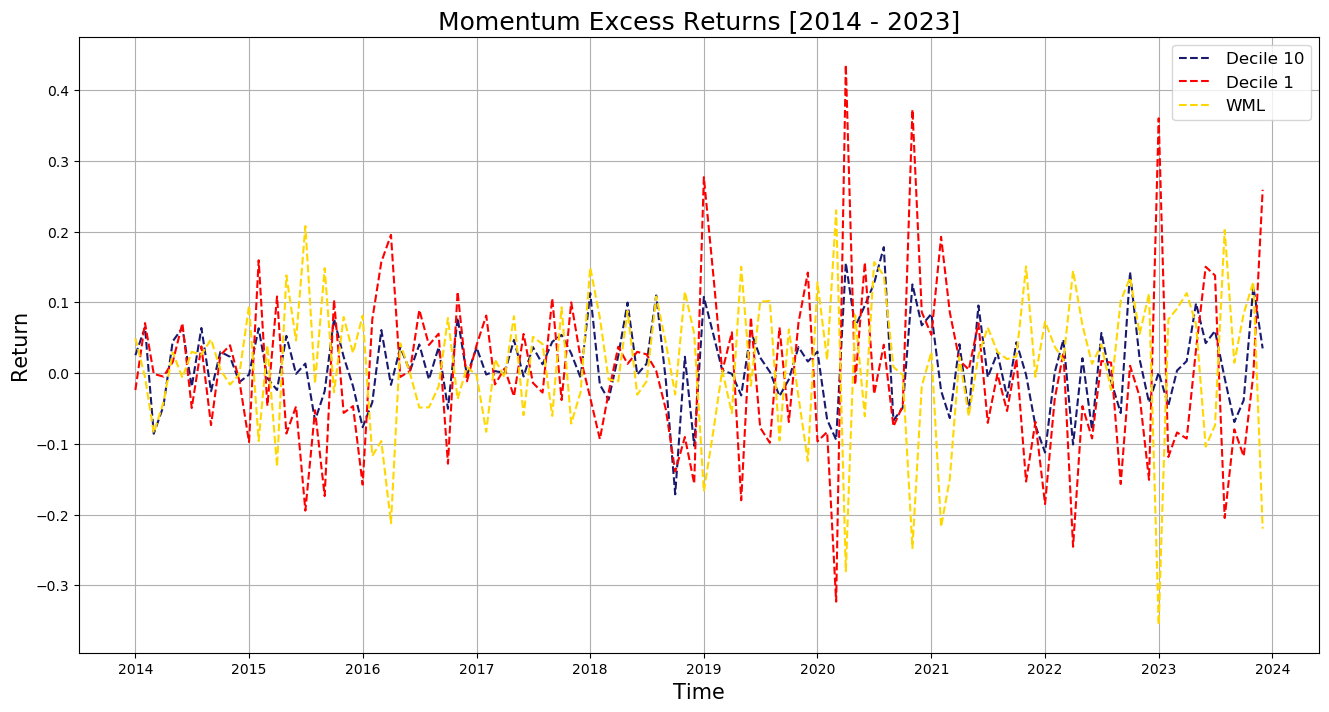

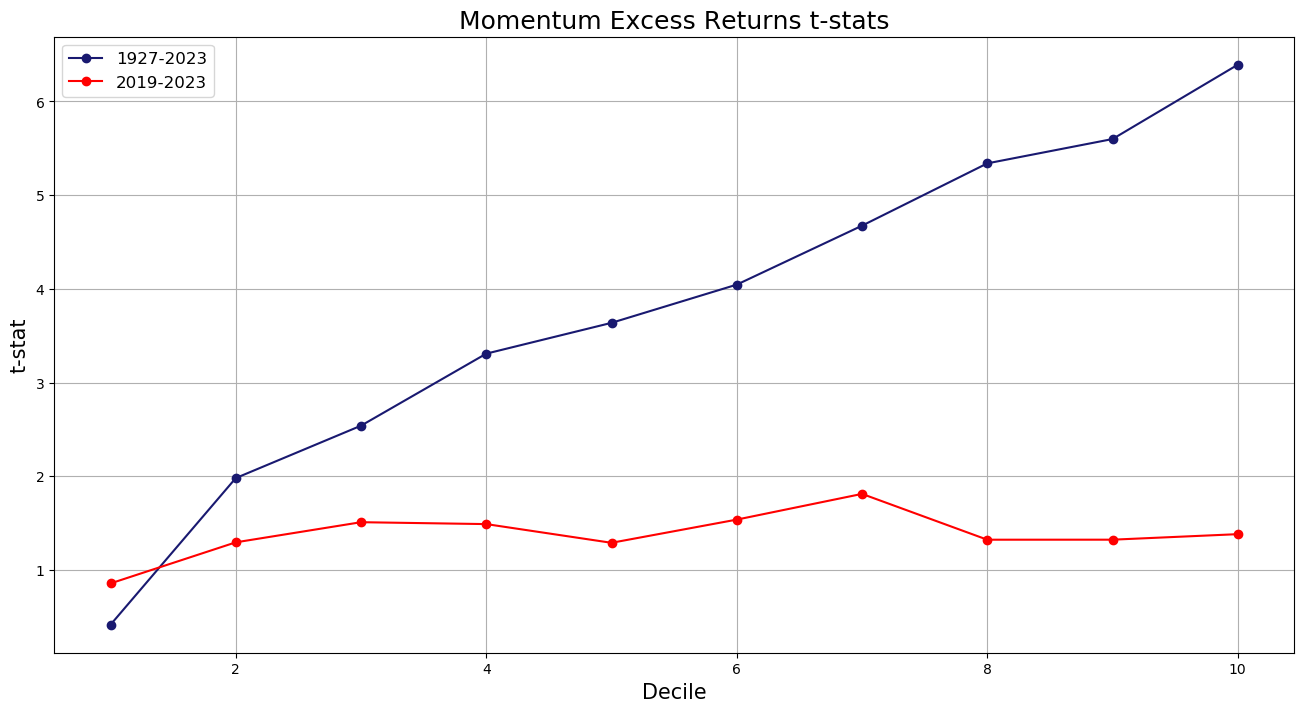

decile,1,2,3,4,5,6,7,8,9,10,WML
Excess Return,1.4327,5.6188,6.2329,7.2985,7.6281,8.2030,8.9948,9.9834,11.0216,14.5437,16.3230
Volatility,34.0187,27.9494,24.1748,21.7296,20.6571,19.9740,18.9534,18.4162,19.3886,22.4092,27.1365
Sharpe Ratio,0.0421,0.2010,0.2578,0.3359,0.3693,0.4107,0.4746,0.5421,0.5685,0.6490,0.6015
Skewness,1.6038,1.6241,1.3249,1.1230,1.3971,0.8356,0.0698,0.0289,-0.2152,-0.4868,-2.1623
Ex_Ret t-stat-all,0.4148,1.9800,2.5393,3.3080,3.6369,4.0448,4.6740,5.3390,5.5987,6.3920,5.9217
Ex_Ret t-stat-5yr,0.8557,1.2942,1.5091,1.4888,1.2891,1.5368,1.8112,1.3222,1.3225,1.3814,-0.1019
corr w/ original,0.9712,0.9651,0.9614,0.9693,0.9721,0.9833,0.9810,0.9850,0.9775,0.9875,0.9484


In [114]:
# Runs all the functions and prints the required results
def driver(download_data=False, process_data=False, recompute_ranking_returns=False):
    # Download the data only if needed
    if download_data == True:
        print("Downloading data ...")
        download_raw_crsp_data(data_dir, wrds_id)
        download_ff3_monthly_data(data_dir)
    else:
        print("Skipped data downloading!")
    
    # Process raw data only if needed
    if process_data == True:
        print("Processing raw data ...")
        process_raw_data()
    else:
        print("Skipped raw data processing!")      
    
    # Commpute ranking return
    #CRSP_Stocks_Momentum = compute_ranking_returns(recompute_ranking_returns)

    # Define the monthly momentum portfolio decile of each stock
    #CRSP_Stocks_Momentum = pd.read_pickle(data_dir + 'CRSP_Stocks_Momentum.pkl')
    #CRSP_Stocks_Momentum_decile = PS3_Q2(CRSP_Stocks_Momentum)
    
    # Load stored FF3, DM and KRF returns as a dataframe
    FF_mkt = pd.read_pickle(data_dir + 'ff3_monthly.pkl')    
    DM_returns = pd.read_pickle(data_dir + 'DM_returns.pkl')    
    KRF_returns = pd.read_pickle(data_dir + 'KRF_returns.pkl')
    
    # Calculate the monthly momentum portfolio decile returns -
    # as defined by both Daniel and Moskowitz (2016) and Kenneth R. French
    #CRSP_Stocks_Momentum_decile = pd.read_pickle(data_dir + 'CRSP_Stocks_Momentum_decile.pkl')
    #CRSP_Stocks_Momentum_returns = PS3_Q3(CRSP_Stocks_Momentum_decile, FF_mkt)

    # Display Q4 results
    pd.set_option("display.precision", 4)
    CRSP_Stocks_Momentum_returns = pd.read_pickle(data_dir + 'CRSP_Stocks_Momentum_returns.pkl')
    result_ps3_q4 = PS3_Q4(CRSP_Stocks_Momentum_returns, DM_returns)
    display(result_ps3_q4)

    # Display Q5 results
    result_ps3_q5 = PS3_Q5(CRSP_Stocks_Momentum_returns, KRF_returns)
    display(result_ps3_q5)
    pd.set_option("display.precision", 4)
    
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader
import wrds
import os
from pandas.tseries.offsets import *
import datetime
from scipy.stats import ttest_1samp
from scipy.stats import skew
import math

# Directory to store the downloaded data
data_dir = 'data\\'

# WRDS login id
wrds_id = 'smarty_iitian'

# DM returns file name
DM_returns_file = "m_m_pt_tot.txt"

# KRF returns file name
KRF_returns_file = "10_Portfolios_Prior_12_2.csv"

# Filter relevant date - Reference - Assignment Instruction:
# "Your output should be from 1927-2023."
min_year = 1927
max_year = 2023

# Specify whether we need to download the raw data or not
download_data = False

# Specify whether we need to process the raw data or not
process_data = False

# Specify whether we need to recompute ranking returns or not
recompute_ranking_returns = False

driver(download_data, process_data, recompute_ranking_returns)